<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_25_biGRU_1layer_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU Prototype With Attention

Previous notebook we implemented a [single layer GRU](https://github.com/sv650s/sb-capstone/blob/master/2019-07-22-GRU_prototype.ipynb) without attention

For this notebook, we will implement a 1 layer bidirectional GRU network with attention and 3 dense layer architecture


As before, I am using some utility functions so I don't have copy so much code around. Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, Dropout, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()


import logging

logging.basicConfig(level=logging.INFO)


Using TensorFlow backend.


In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"




In [4]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
df = pd.read_csv(f"{DATA_FILE}")

## Preprocessing

*  Preprocessing data file and create the right inputs for Keras models
     *   Features:
        * tokenize
        * pad features into sequence
     *   Labels:
       *  one hot encoder
* split between training and testing

See [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py) for souce code

In [6]:
X_train, X_test, y_train, y_test, tokenizer, max_sequence_length = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                      keep_percentile=0.99)

One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Building Our GRU Model

In [0]:
from keras.engine.topology import Layer
from keras import backend as K
import keras


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
MODEL_NAME = "GRU_bi1layer_attention"
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(tokenizer.word_counts)+1
GRU_DIM = 250 # total GRU units

In [9]:
from keras.layers import CuDNNGRU

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_sequence_length))
model.add(Bidirectional(CuDNNGRU(GRU_DIM*2, return_sequences=True)))
model.add(AttentionLayer(max_sequence_length))
model.add(Dense(GRU_DIM*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(GRU_DIM, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


W0730 01:08:12.355796 140182199433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 01:08:12.359031 140182199433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 01:08:12.362593 140182199433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 01:08:15.502825 140182199433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 01:08:15.520892 

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 186, 1000)         2406000   
_________________________________________________________________
attention_layer_1 (Attention (None, 1000)              1186      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1255      
Total para

In [11]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='auto', 
                           verbose=1,
                          restore_best_weights=True)

mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE, 
                     embedding=EMBED_SIZE,
                     tokenizer=tokenizer)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[reduce_lr, early_stop])

W0730 01:08:15.804737 140182199433088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 127s 2ms/step - loss: 0.9638 - acc: 0.6338 - val_loss: 0.8640 - val_acc: 0.6661
Epoch 2/50
67225/67225 [==============================] - 121s 2ms/step - loss: 0.7782 - acc: 0.6960 - val_loss: 0.8558 - val_acc: 0.6767
Epoch 3/50
67225/67225 [==============================] - 121s 2ms/step - loss: 0.6875 - acc: 0.7322 - val_loss: 0.8520 - val_acc: 0.6731
Epoch 4/50
67225/67225 [==============================] - 121s 2ms/step - loss: 0.6041 - acc: 0.7678 - val_loss: 0.9444 - val_acc: 0.6683
Epoch 5/50
67225/67225 [==============================] - 116s 2ms/step - loss: 0.5221 - acc: 0.8024 - val_loss: 1.0595 - val_acc: 0.6499
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


## Evaluating the Model

In [12]:
mw.evaluate(X_test, y_test)

Running model.evaluate...
28011/28011 [==============================] - 20s 712us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


In [13]:
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Accuracy: 67.59%


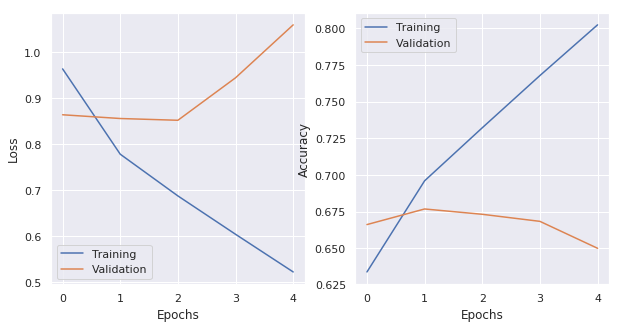

In [14]:
pu.plot_network_history(mw.network_history)

In [15]:
mw.confusion_matrix

array([[ 2943,   307,   334,    57,   327],
       [  733,   313,   418,   136,   271],
       [  379,   255,   773,   481,   643],
       [  111,    78,   460,  1293,  2810],
       [  142,    37,   239,   861, 13610]])

In [16]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.68      0.74      0.71      3968
           2       0.32      0.17      0.22      1871
           3       0.35      0.31      0.33      2531
           4       0.46      0.27      0.34      4752
           5       0.77      0.91      0.84     14889

    accuracy                           0.68     28011
   macro avg       0.51      0.48      0.49     28011
weighted avg       0.64      0.68      0.65     28011



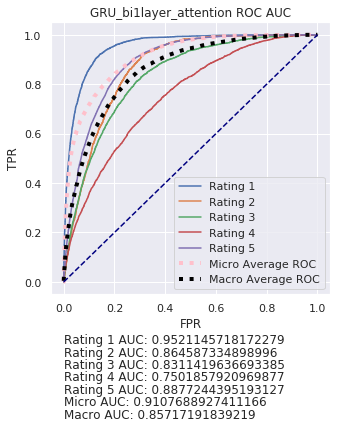

In [17]:
fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

## Save off files

In [18]:
mw.save(DRIVE_DIR)
mw.get_report().to_df()

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi1layer_attention-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi1layer_attention-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-GRU_bi1layer_attention-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


,accuracy,classification_report,confusion_matrix,description,embedding,evaluate_time_min,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,predict_time_min,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.675877,"{""1"": {""precision"": 0.6831476323119777, ""recal...","[[2943, 307, 334, 57, 327], [733, 313, 418, 13...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,12.16,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 4.159214740257039e-05, 4...",0.847055,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_bi1layer_attention,<keras.callbacks.History object at 0x7f7e08518...,12.16,"{""auc_1"": 0.9521145718172279, ""auc_2"": 0.86458...",success,2019-07-30 01:19:27,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.01512096...",84032.0,186.0,12.16
